## Geometry

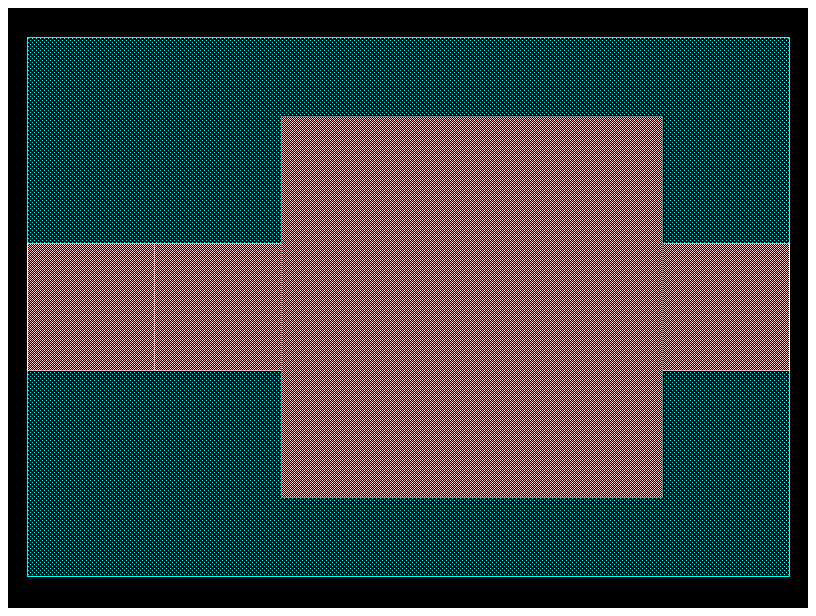

In [14]:
import os
import math
import numpy as np
import luminescent as lumi
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import matplotlib.pyplot as plt


# folder for saving config and results
path = os.path.join("studies", "test_opt")

wavelength = 1.3  # characteristic wavelength
wavelengths = [wavelength]

# layers
WG = (1, 0)  # waveguide layer
DESIGN = (100, 0)  # design region layer
CLAD = (2, 0)  # cladding layer

# makes gdsfactory component to be optimized. has rectangular design region with port stubs. ports numbered clockwise from bottom left
length = 1.2
width = 1.2
w_wg = 0.4
l_wg = 1 * w_wg
c = gf.Component()
dut = lumi.mimo(
    length,
    width,
    west=1,
    east=1,
    w_wg=w_wg,
    l_wg=l_wg,
    layer_wg=WG,
    layer_design=DESIGN,
)
# metadata. here we include design region info containing port locations useful for loading the optimized component after optimization
info = {"designs": [{"ports": dut.info.ports}]}
dut = c << dut

# margin extensions
lateral_port_margin = height_port_margin = 0.2
xmargin = 1.25 * lateral_port_margin
zmargin = 1.25 * height_port_margin
# source_port_margin = 1.0 * (w_wg + 2 * lateral_port_margin)
source_port_margin = w_wg
ext = c << gf.components.straight(source_port_margin, width=w_wg)
ext.connect("o2", dut.ports["o1"])

# add ports
for i in range(2):
    i+=1
    c.add_port(f"o{i}", port=dut.ports[f"o{i}"])

c << gf.components.bbox(component=c, layer=CLAD, top=xmargin, bottom=xmargin)
c.plot()

## Solve

saving mode plots to studies\test_opt\modes\1
showing modes for first wavelength 
using simulation folder C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\studies\test_opt
0.04642857142857143
0.04642857142857143
0.04642857142857143
0.04642857142857143
0.04642857142857143
loading problem from C:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\studies\test_opt

failed


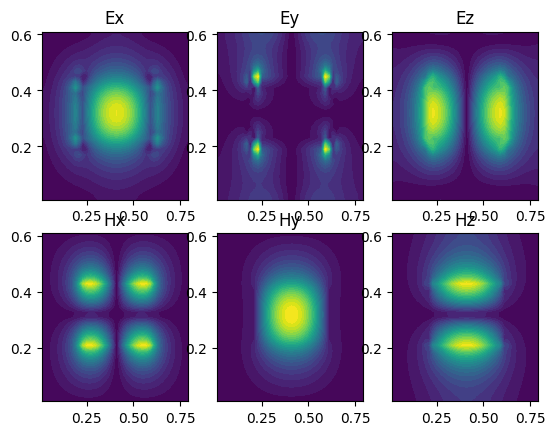

In [15]:
# layer stack. lower mesh order layers override higher mesh order layers. for 2.5D problems as is here, the mesher will slice thru middle of 'core' layer
thickness = 0.22
nSi = 3.5
material_library = {
    "Si": lumi.Material(12.25),
    "SiO2": lumi.Material(2.25),
    "design": lumi.PlaceholderMaterial(nSi),
}
material_library['background']=material_library['SiO2']

layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            thickness=thickness,
            zmin=0.0,
            material="design",
            mesh_order=0,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=WG),
            thickness=thickness,
            zmin=0.0,
            material="Si",
            mesh_order=1,
        ),
    }
)  

# time [periods at characteristic wavelength ]
tmax = (source_port_margin + 2 * l_wg + 1. * (length + width)) / wavelength * nSi

# each mode will be solved for sources and monitors
lx=w_wg + 2 * lateral_port_margin
ly=thickness + 2 * height_port_margin
modes = [lumi.Mode(wavelengths=[wavelength],start=(-lx/2,-height_port_margin), stop=(lx/2,height_port_margin+thickness), nmodes=1)]
sources = [
    lumi.Source(
        "o1",
        source_port_margin=source_port_margin,
        wavelength=wavelength,
        bandwidth=0.2,
    )
]
designs = [
    lumi.Design(
        name="d1",
        layer=DESIGN,
        lmin=0.1,
        fill_material="Si",
        void_material="SiO2",
    )
]
# optimization targets of tmax params.
# o1@0 means optical port 1 on mode 0 (fundamental mode)
targets = [
    lumi.Target(
        key=f"To2@0,o1@0",
        target=1.0,
        weight=1,
        wavelength=wavelength,
    )
]

optimizer = lumi.Optimizer(stoploss=0.2, iters=10,gradckptat=10,)
lumi.make(
    path=path,  # path to make problem folder
    component=c,
    wavelengths=wavelengths,
    wavelength=wavelength,
    modes=modes,
    info=info,
    sources=sources,
    #
    zmin=-zmargin,
    zmax=thickness + zmargin,
    #
    material_library=material_library,
    layer_stack=layer_stack,
    #
    nres=4,  # number of grid points per wavelength in material (not vacuum)
    relative_pml_depths=[1, 1, 0.3],
    relative_courant=0.9,
    tmax=tmax,
    saveat=10,
    views=[lumi.View("Hz")],
    #
    targets=targets,
    optimizer=optimizer,
    designs=designs,
    # load_saved_designs=True
)
lumi.solve(path)